Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]



➡️ Training Original Model
Epoch 1, Loss: 204.9571
Epoch 2, Loss: 125.8374
Epoch 3, Loss: 101.2701
Epoch 4, Loss: 85.3232
Epoch 5, Loss: 72.8822
Epoch 6, Loss: 65.6439
Epoch 7, Loss: 59.9792
Epoch 8, Loss: 54.0679
Epoch 9, Loss: 49.6662
Epoch 10, Loss: 45.3714

🔍 Evaluating Original Model
Accuracy: 91.99%

✂️ Applying Structured Pruning (30%) to New Copy

📊 Sparsity After Pruning
conv1.weight: 29.69% sparsity
bn1.weight: 0.00% sparsity
layer1.0.conv1.weight: 29.69% sparsity
layer1.0.bn1.weight: 0.00% sparsity
layer1.0.conv2.weight: 29.69% sparsity
layer1.0.bn2.weight: 0.00% sparsity
layer1.1.conv1.weight: 29.69% sparsity
layer1.1.bn1.weight: 0.00% sparsity
layer1.1.conv2.weight: 29.69% sparsity
layer1.1.bn2.weight: 0.00% sparsity
layer2.0.conv1.weight: 29.69% sparsity
layer2.0.bn1.weight: 0.00% sparsity
layer2.0.conv2.weight: 29.69% sparsity
layer2.0.bn2.weight: 0.00% sparsity
layer2.0.downsample.0.weight: 29.69% sparsity
layer2.0.downsample.1.weight: 0.00% sparsity
layer2.1.conv1.wei

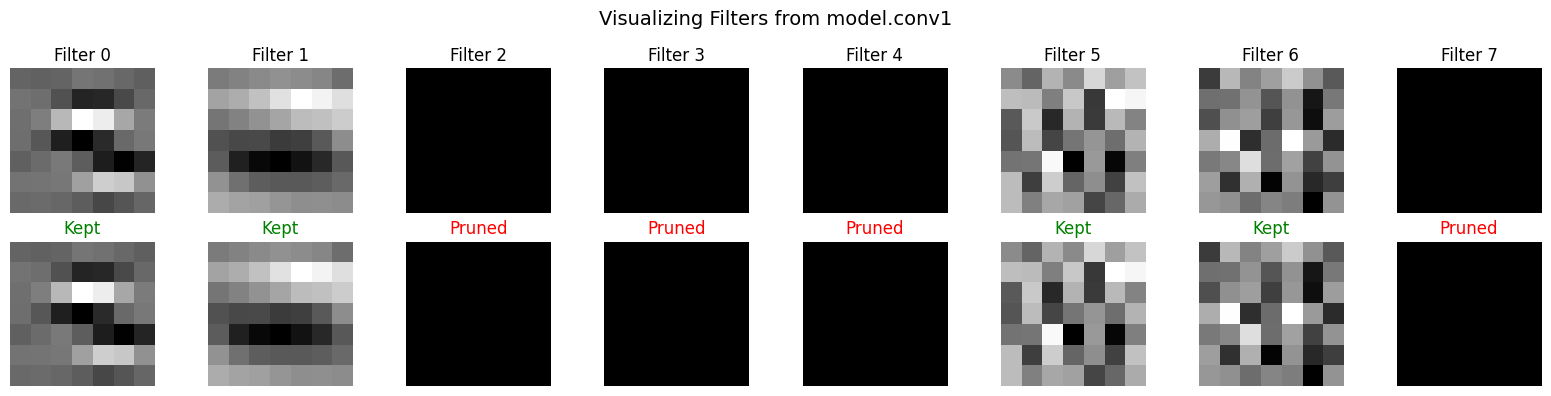


📈 Final Accuracy Comparison:
Original Accuracy: 91.99%
Pruned + Retrained Accuracy: 94.05%

📉 Parameter Count Before vs After Pruning:
Original Parameters: 11,181,642
Pruned Parameters:   11,181,642
Reduction:           0.00%

🖼️ Visualizing 5 Predictions (True/False)


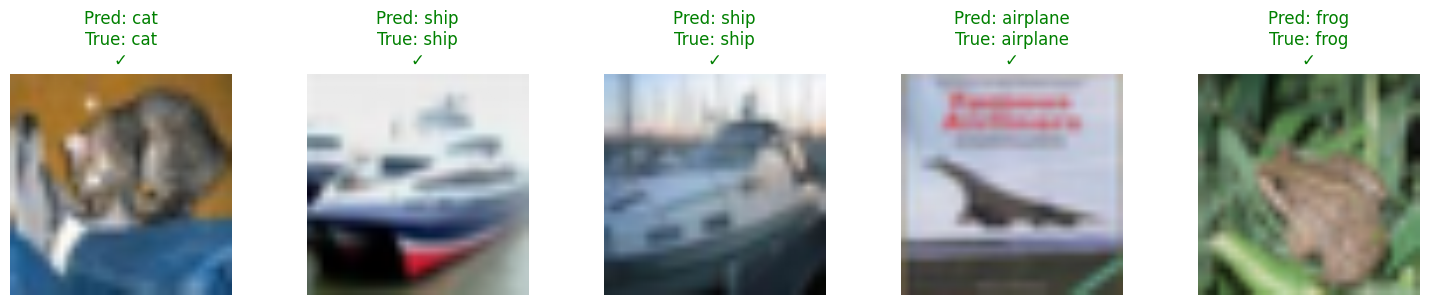


✅ Model saved as resnet18_structured_pruned_cifar10.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ SETUP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from google.colab import files

# ✅ Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ TRANSFORMS & DATA
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# ✅ MODEL
from torchvision.models import resnet18, ResNet18_Weights

def get_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

original_model = get_model()

# ✅ TRAINING + EVAL
criterion = nn.CrossEntropyLoss()

def train_model(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc

# ✅ CUSTOM STRUCTURED PRUNING
def custom_prune_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
    return model

# ✅ SPARSITY ANALYSIS
def analyze_sparsity(model):
    total_zeros, total_params = 0, 0
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            zeros = torch.sum(param == 0).item()
            total = param.numel()
            total_zeros += zeros
            total_params += total
            print(f"{name}: {100 * zeros / total:.2f}% sparsity")
    print(f"\nTotal sparsity: {100 * total_zeros / total_params:.2f}%")

# ✅ VISUALIZE FILTERS
def visualize_pruned_filters(model):
    conv1 = model.conv1.weight.detach().cpu()
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    fig.suptitle("Visualizing Filters from model.conv1", fontsize=14)
    for i in range(8):
        img = conv1[i].mean(0)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Filter {i}")
        axes[0, i].axis('off')
        is_zero = (conv1[i] == 0).all()
        axes[1, i].imshow(img if not is_zero else torch.zeros_like(img), cmap='gray')
        axes[1, i].set_title("Pruned" if is_zero else "Kept", color='red' if is_zero else 'green')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# ✅ VISUALIZE PREDICTIONS
def visualize_predictions(model, loader):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    class_names = test_set.classes

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for idx in range(images.size(0)):
                if images_shown >= 5:
                    break
                img = images[idx].cpu().permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
                axes[images_shown].imshow(img)
                true_label = class_names[labels[idx]]
                pred_label = class_names[predicted[idx]]
                correct = pred_label == true_label
                axes[images_shown].set_title(f"Pred: {pred_label}\nTrue: {true_label}\n{'✓' if correct else '✗'}", color='green' if correct else 'red')
                axes[images_shown].axis('off')
                images_shown += 1

            if images_shown >= 5:
                break

    plt.tight_layout()
    plt.show()

# ✅ PARAMETER COUNT
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ✅ TRAIN ORIGINAL MODEL
print("\n➡️ Training Original Model")
optimizer = optim.Adam(original_model.parameters(), lr=0.001)
train_model(original_model, train_loader, optimizer, epochs=10)

print("\n🔍 Evaluating Original Model")
original_acc = evaluate(original_model, test_loader)

# ✅ COPY & APPLY STRUCTURED PRUNING
print("\n✂️ Applying Structured Pruning (30%) to New Copy")
pruned_model = copy.deepcopy(original_model)
custom_prune_model(pruned_model, amount=0.3)

print("\n📊 Sparsity After Pruning")
analyze_sparsity(pruned_model)

# ✅ RETRAIN PRUNED MODEL
print("\n🔁 Retraining Pruned Model (10 epochs)")
optimizer = optim.Adam(pruned_model.parameters(), lr=0.0005)
train_model(pruned_model, train_loader, optimizer, epochs=10)

print("\n🔍 Evaluating Pruned + Retrained Model")
pruned_acc = evaluate(pruned_model, test_loader)

# ✅ VISUALIZE FILTERS
print("\n🖼️ Visualizing Pruned Filters")
visualize_pruned_filters(pruned_model)

# ✅ COMPARE ACCURACY
print("\n📈 Final Accuracy Comparison:")
print(f"Original Accuracy: {original_acc:.2f}%")
print(f"Pruned + Retrained Accuracy: {pruned_acc:.2f}%")

# ✅ PARAMETER COMPARISON
original_params = count_parameters(original_model)
pruned_params = count_parameters(pruned_model)
reduction = 100 * (original_params - pruned_params) / original_params

print(f"\n📉 Parameter Count Before vs After Pruning:")
print(f"Original Parameters: {original_params:,}")
print(f"Pruned Parameters:   {pruned_params:,}")
print(f"Reduction:           {reduction:.2f}%")

# ✅ VISUALIZE 5 PREDICTIONS
print("\n🖼️ Visualizing 5 Predictions (True/False)")
visualize_predictions(pruned_model, test_loader)

# ✅ SAVE MODEL
model_path = "resnet18_structured_pruned_cifar10.pth"
torch.save(pruned_model.state_dict(), model_path)
print(f"\n✅ Model saved as {model_path}")
files.download(model_path)
